In [2]:
import numpy as np

y_obs = np.loadtxt("./data/LabelMe/answers.txt",dtype='int16') #not annotation symbol ==-1

T_weights = np.sum(y_obs != -1,axis=0) #number of annotations per annotator
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) 
print("Shape (n_samples,n_annotators)= ",y_obs.shape)

Remove 18 annotators that do not annotate on this set 
Shape (n_samples,n_annotators)=  (1000, 59)


In [ ]:
from codeE.representation import set_representation
r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

from codeE.methods import LabelAggregation
label_A = LabelAggregation(scenario="global")
mv_soft = label_A.predict(r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

Global representation shape (N,K)=  (1000, 8)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./data/LabelMe/"

### Load Data and preprocess

In [4]:
Xstd_train = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

Xstd_val = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

Xstd_test = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",Xstd_train.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


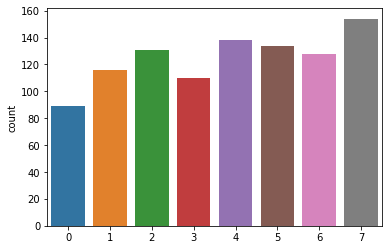

In [6]:
sns.countplot(Z_train)
plt.show()

### Load annotations 

In [4]:
# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
#y_obs = np.loadtxt(folder+"answers_GLOBAL.txt",dtype='int16') 

T_weights = np.sum(y_obs != -1,axis=0) #number of annotations per annotator
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) 

N,T = y_obs.shape
Kl = np.max(y_obs)+1 #asumming classification scenario
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


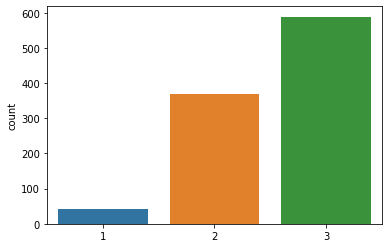

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


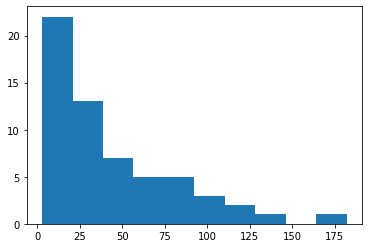

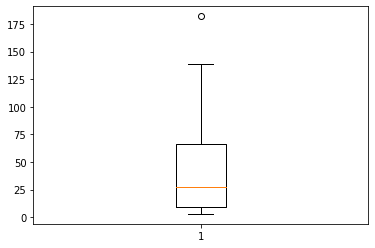

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  43.16949152542373


In [8]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Generate Matrix representation of both scenarios

In [5]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (1000, 59, 8)
Global representation shape (N,K)=  (1000, 8)


### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [11]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (59, 8, 8)


array([[[0.7778, 0.1111, 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.7857, 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.2308, 0.7692, ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 1.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.0556, 0.2222, 0.5556]],

       [[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.125 , 0.125 , 0.125 , ..., 0.125 , 0.125 , 0.125 ],
        ...,
        [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.5   , 0.5   ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.5   , 0.5   ]],

       [[0.375 , 0.125 , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.75  , 0.25  , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0. 

Global matrix shape (K,K)=  (8, 8)


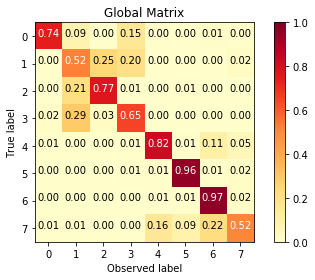

In [12]:
from codeE.utils import generate_Global_conf

#confe_matrix_G = generate_Global_conf(Z_train, y_obs_categorical)
confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, np.arange(8), title= "Global Matrix")

#### Delta Convergence criteria

In [13]:
from codeE.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from codeE.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [13]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB, model_UB.input)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained IDeal Model, Epochs to converge = 13


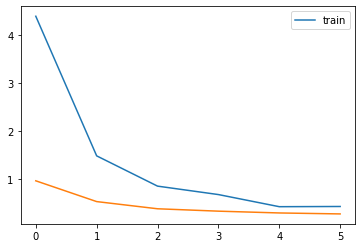

In [15]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [15]:
from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.972
Test accuracy of model = 0.9208754208754208


In [16]:
from codeE.evaluation import f1score_model
print("Train accuracy of model =", f1score_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", f1score_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.9737286206055469
Test accuracy of model = 0.9214999369580521


## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [14]:
from codeE.methods import LabelAggregation
label_A = LabelAggregation(scenario="global")

mv_soft = label_A.infer(  r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

array([1, 2, 1, 4, 5, 2, 0, 4, 2, 5, 0, 1, 2, 3, 1, 3, 6, 4, 7, 4, 1, 1,
       2, 1, 3, 6, 0, 4, 6, 2, 4, 3, 6, 6, 5, 7, 4, 0, 5, 4, 5, 5, 2, 0,
       4, 2, 1, 5, 1, 6, 1, 7, 1, 0, 1, 6, 6, 7, 4, 4, 2, 3, 0, 5, 1, 1,
       4, 5, 2, 6, 4, 1, 7, 6, 6, 1, 5, 6, 6, 4, 1, 3, 6, 5, 4, 5, 6, 4,
       0, 4, 7, 0, 3, 3, 5, 5, 7, 4, 1, 3, 5, 4, 4, 1, 7, 7, 6, 2, 4, 2,
       2, 1, 7, 4, 0, 7, 7, 4, 0, 1, 6, 4, 7, 7, 2, 2, 2, 4, 1, 3, 1, 6,
       0, 6, 6, 1, 6, 0, 4, 6, 0, 3, 0, 5, 7, 0, 4, 3, 2, 3, 4, 0, 5, 6,
       4, 3, 0, 6, 1, 7, 3, 1, 7, 2, 1, 7, 0, 3, 5, 5, 1, 0, 5, 2, 6, 2,
       5, 4, 2, 5, 5, 2, 5, 4, 3, 3, 6, 4, 0, 1, 0, 4, 7, 2, 5, 0, 7, 4,
       1, 0, 0, 5, 0, 3, 6, 4, 1, 7, 1, 1, 1, 4, 6, 5, 5, 4, 1, 6, 1, 2,
       1, 5, 5, 4, 4, 7, 2, 0, 2, 0, 1, 5, 2, 4, 3, 5, 6, 6, 1, 1, 4, 1,
       6, 4, 2, 6, 2, 7, 5, 4, 3, 4, 2, 7, 6, 4, 2, 1, 5, 7, 3, 3, 5, 6,
       1, 6, 6, 1, 7, 3, 5, 2, 6, 5, 1, 1, 6, 1, 1, 5, 1, 4, 4, 1, 5, 3,
       6, 2, 6, 4, 3, 6, 1, 4, 1, 3, 6, 0, 2, 6, 0,

In [16]:
from codeE.methods import LabelAggregation
label_A = LabelAggregation(scenario="individual")

mv_soft = label_A.infer(  y_obs_categorical, 'softMV')
mv_hard = label_A.predict(y_obs_categorical, 'hardMV')
mv_soft

array([[0.    , 0.6667, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.6667, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.3333, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.3333, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [19]:
print("ACC MV on train:",np.mean(mv_hard==Z_train))

ACC MV on train: 0.769


### generate confusion matrix to understand MV

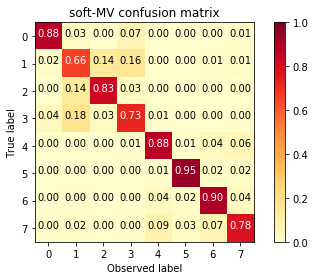

In [20]:
from codeE.utils import generate_confusionM
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotators

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(prob_Yz, np.arange(8), title= "soft-MV confusion matrix")

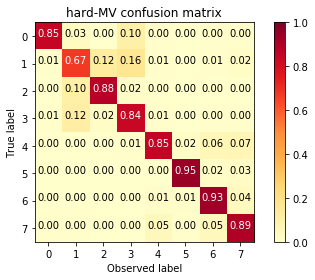

In [21]:
prob_Yz = generate_confusionM(mv_hard, r_obs) #confusion matrix of all annotators
plot_confusion_matrix(prob_Yz, np.arange(8), title= "hard-MV confusion matrix")

### Metrics to compare the estimation of confusion matrix

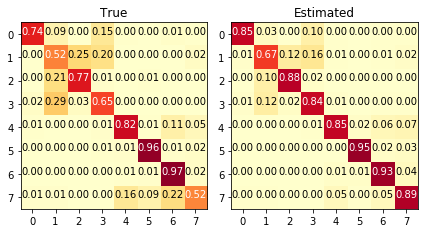

In [22]:
from codeE.utils import compare_conf_mats
compare_conf_mats(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

In [23]:
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


##### Weighted

In [213]:
from codeE.methods import LabelAggregation
label_A = LabelAggregation(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)
Wmv_soft

array([[0.    , 0.3309, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3374, 0.6626, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.306 , 0.1913, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.0848, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [214]:
print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))

ACC MV on train: 0.762


### Dawid and Skene model

In [14]:
from codeE.methods import LabelInference_EM as DS

DS_model = DS(init_Z='softmv') 
#DS_model = DS(init_Z='softmv', priors="None", fast=False) 
    
# if you want you can initialize step E forcing some method
#DS_model.init_E(y_obs_categorical)
#DS_model.get_qestimation()

hist = DS_model.fit(y_obs_categorical, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Z marginal shape (8,)
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2837.160	
Iter 2/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2760.562	Tol1: 0.02700	Tol2: 0.25264	
Iter 3/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2734.589	Tol1: 0.00941	Tol2: 0.10178	
Iter 4/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2723.378	Tol1: 0.00410	Tol2: 0.08455	
Iter 5/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2717.710	Tol1: 0.00208	Tol2: 0.14913	
Iter 6/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2714.123	Tol1: 0.00132	Tol2: 0.30754	
Iter 7/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2712.104	Tol1: 0.00074	Tol2: 0.13994	
Iter 8/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2710.701	Tol1: 0.00052	Tol2: 0.05798	
Iter 9/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2709.480	Tol1: 0.00045	Tol2: 0.04514	
Iter 10/50 

In [15]:
print("p(z) = ",DS_model.get_marginalZ())

ds_labels = DS_model.infer() #could infer/predict on the trainint set only
ds_labels

p(z) =  [0.0766 0.1127 0.1443 0.1139 0.1431 0.1434 0.1716 0.0944]


array([[0.    , 0.0633, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.1574, 0.8426, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.999 , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.0345, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0022, 0.9978, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [16]:
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC D&S on train: 0.804


In [17]:
prob_Yzt = DS_model.get_confusionM() # estimate of conf_matrix_I

from codeE.evaluation import Individual_D, D_JS, D_NormF
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.18280751182126098
Individual D_NormF =  0.14954937672463514


### Second Phase
train a predictive model over the inference/aggregation label

In [19]:
from codeE.evaluation import accuracy_model

In [20]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

#Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
#Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

print("Train accuracy of model =", accuracy_model(model_mvsoft, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, Xstd_test, Z_test))

Trained model over soft-MV, Epochs to converge = 15
Train accuracy of model = 0.836
Test accuracy of model = 0.8114478114478114


In [21]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard, num_classes=Kl)
mv_hard_onehot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [22]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

#Z_train_pred = model_mvhard.predict_classes(Xstd_train)
#Z_test_pred = model_mvhard.predict_classes(Xstd_test)
print("Train accuracy of model =", accuracy_model(model_mvhard, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, Xstd_test, Z_test))

Trained model over hard-MV, Epochs to converge = 12
Train accuracy of model = 0.808
Test accuracy of model = 0.7954545454545454


In [23]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

#Z_train_pred = model_ds.predict_classes(Xstd_train)
#Z_test_pred = model_ds.predict_classes(Xstd_test)

print("Train accuracy of model =", accuracy_model(model_ds, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_ds, Xstd_test, Z_test))

Trained model over D&S, Epochs to converge = 11
Train accuracy of model = 0.85
Test accuracy of model = 0.8392255892255892


## Raykar Model (joint predict model)

In [14]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [15]:
from codeE.methods import ModelInference_EM as Raykar
R_model = Raykar(init_Z="softmv")
#R_model = Raykar(init_Z="softmv", priors='laplace', n_init_Z=3)

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
R_model.set_model(model_R, **args)

# if you want you can initialize step E forcing some method
#R_model.init_E(y_obs_categorical, method="hardmv")
#R_model.get_qestimation()

In [16]:
#logL_hists,i_r = R_model.multiples_run(20, Xstd_train,y_obs_categorical,
#                                        max_iter=EPOCHS_BASE, tolerance=TOL)

R_model.fit(Xstd_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.68 sec)	logL: -1931.212	
Iter 2/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -1357.881	Tol1: 0.29688	Tol2: 1.72877	
Iter 3/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -1200.345	Tol1: 0.11602	Tol2: 4.25495	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -1127.335	Tol1: 0.06082	Tol2: 1.44411	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -1081.122	Tol1: 0.04099	Tol2: 0.48266	
Iter 6/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -1045.601	Tol1: 0.03286	Tol2: 0.55091	
Iter 7/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -1018.889	Tol1: 0.02555	Tol2: 0.05433	
Iter 8/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -994.535	Tol1: 0.02390	Tol2: 0.18615	
Iter 9/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -974.948	Tol1: 0.01969	Tol2: 0.73202	
Iter 10/50 
M step: done,  E step: 

M step: done,  E step: done //  (in 0.07 sec)	logL: -1077.851	Tol1: 0.04065	Tol2: 0.95947	
Iter 6/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -1044.463	Tol1: 0.03098	Tol2: 3.88419	
Iter 7/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -1018.397	Tol1: 0.02496	Tol2: 0.34897	
Iter 8/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -998.237	Tol1: 0.01980	Tol2: 0.21310	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -981.771	Tol1: 0.01650	Tol2: 0.02418	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.60 sec)	logL: -1975.771	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -1370.969	Tol1: 0.30611	Tol2: 0.31922	
Iter 3/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -1214.183	Tol1: 0.11436	Tol2: 0.11353	
Iter 4/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -1125.583	Tol1: 0.07297	Tol2: 2.90713	
Iter 5/50 
M step: done,  E 

([[-1931.2119140625,
   -1357.880615234375,
   -1200.344970703125,
   -1127.335205078125,
   -1081.122314453125,
   -1045.6009521484375,
   -1018.88916015625,
   -994.535400390625,
   -974.9481201171875,
   -957.263671875,
   -943.63037109375,
   -929.8033447265625],
  [-1962.452392578125,
   -1321.419921875,
   -1175.78173828125,
   -1105.334228515625,
   -1061.024658203125,
   -1031.756591796875,
   -1009.5701904296875,
   -986.1236572265625,
   -966.842529296875,
   -952.0892944335938,
   -933.2646484375,
   -923.3026123046875,
   -910.9246826171875],
  [-1962.6260986328125,
   -1324.500732421875,
   -1175.413330078125,
   -1099.0198974609375,
   -1063.413818359375,
   -1040.502685546875,
   -1016.16552734375,
   -994.080322265625,
   -969.454345703125,
   -950.5677490234375,
   -933.5577392578125],
  [-1727.8267822265625,
   -1248.421142578125,
   -1124.09033203125,
   -1068.717041015625,
   -1038.0736083984375,
   -1006.51171875,
   -985.8775634765625,
   -967.3939208984375,
   -9

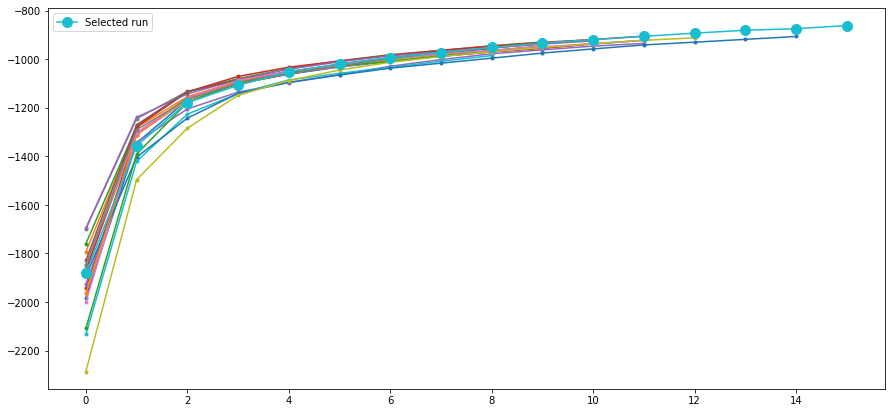

In [68]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [69]:
raykar_fx = R_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

Train accuracy of model = 0.862
Test accuracy of model = 0.8543771043771043


In [70]:
prob_Yzt = R_model.get_confusionM() # estimate of conf_matrix_I

from codeE.evaluation import Individual_D, D_JS, D_NormF
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.17539954712750433
Individual D_NormF =  0.14654303803029706


In [71]:
prob_Yz = prob_Yzt.mean(axis=0)
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.04375869330577313
Global D (based on normalized Frobenius) = 0.05379455164074898


In [30]:
#how good estimate the annotations ?
prob_Y_xt = R_model.get_predictions_annot(Xstd_train)
- np.sum(np.sum(y_obs_categorical * np.log(prob_Y_xt +1e-7 ), axis=-1))

953.8341

## Our Proposed - CMM

In [14]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [15]:
from codeE.methods import CMM
CMM_model = CMM(M=M_seted) 
#CMM_model = CMM(M=M_seted, init_Z='softmv', n_init_Z=3, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMM_model.set_model(aux_model, **args)

# if you want you can initialize step E forcing some method
#CMM_model.init_E(r_obs, method="hardmv")
#CMM_model.get_qestimation()

In [16]:
#logL_hists,i_r = CMM_model.multiples_run(20,Xstd_train,r_obs,
#                                               max_iter=EPOCHS_BASE,tolerance=TOL)

CMM_model.fit(Xstd_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.79 sec)	logL: -2686.857	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2013.008	Tol1: 0.25079	Tol2: 1.09739	Tol3: 0.08389	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1856.953	Tol1: 0.07752	Tol2: 0.34975	Tol3: 0.02012	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1772.185	Tol1: 0.04565	Tol2: 0.25603	Tol3: 0.03764	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.252	Tol1: 0.02874	Tol2: 0.18513	Tol3: 0.01594	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1679.988	Tol1: 0.02397	Tol2: 0.17431	Tol3: 0.02029	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.977	Tol1: 0.02798	Tol2: 0.15853	Tol3: 0.01768	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1590.545	Tol1: 0.02598	Tol2: 0.14955	Tol3: 0.02117	
Iter 9/50
M s

M step: done,  E step: done //  (in 0.05 sec)	logL: -1338.690	Tol1: 0.01584	Tol2: 0.05825	Tol3: 0.00729	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1321.891	Tol1: 0.01255	Tol2: 0.04968	Tol3: 0.00678	
Iter 19/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1307.771	Tol1: 0.01068	Tol2: 0.04417	Tol3: 0.00262	
Iter 20/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1292.228	Tol1: 0.01188	Tol2: 0.04822	Tol3: 0.00863	
Iter 21/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1282.057	Tol1: 0.00787	Tol2: 0.03761	Tol3: 0.00682	
Iter 22/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1272.097	Tol1: 0.00777	Tol2: 0.03809	Tol3: 0.00278	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1258.524	Tol1: 0.01067	Tol2: 0.03711	Tol3: 0.00228	
Iter 24/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1247.411	Tol1: 0.00883	Tol2: 0.03782	Tol3: 0.00015	
Iter 25/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1232.740	Tol1: 0.01

M step: done,  E step: done //  (in 0.04 sec)	logL: -1804.412	Tol1: 0.04825	Tol2: 0.25710	Tol3: 0.02805	
Iter 5/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1729.811	Tol1: 0.04134	Tol2: 0.19384	Tol3: 0.00848	
Iter 6/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1688.405	Tol1: 0.02394	Tol2: 0.17664	Tol3: 0.01847	
Iter 7/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1668.487	Tol1: 0.01180	Tol2: 0.14659	Tol3: 0.02669	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1631.428	Tol1: 0.02221	Tol2: 0.11660	Tol3: 0.01865	
Iter 9/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1598.284	Tol1: 0.02032	Tol2: 0.09605	Tol3: 0.01130	
Iter 10/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1585.604	Tol1: 0.00793	Tol2: 0.08289	Tol3: 0.00983	
Iter 11/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1561.679	Tol1: 0.01509	Tol2: 0.07221	Tol3: 0.00612	
Iter 12/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1537.015	Tol1: 0.01579	T

M step: done,  E step: done //  (in 0.07 sec)	logL: -2377.403	Tol1: 0.30364	Tol2: 1.17677	Tol3: 0.19434	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2081.936	Tol1: 0.12428	Tol2: 0.41197	Tol3: 0.03793	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1947.410	Tol1: 0.06462	Tol2: 0.25884	Tol3: 0.01696	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1855.608	Tol1: 0.04714	Tol2: 0.21889	Tol3: 0.02689	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1795.101	Tol1: 0.03261	Tol2: 0.18819	Tol3: 0.02447	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1736.939	Tol1: 0.03240	Tol2: 0.30306	Tol3: 0.02058	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1685.176	Tol1: 0.02980	Tol2: 0.17550	Tol3: 0.01561	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1641.170	Tol1: 0.02611	Tol2: 0.13727	Tol3: 0.01577	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1603.659	Tol1: 0.02286	Tol

M step: done,  E step: done //  (in 0.65 sec)	logL: -3104.338	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2243.197	Tol1: 0.27740	Tol2: 1.06376	Tol3: 0.03178	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1950.107	Tol1: 0.13066	Tol2: 0.31879	Tol3: 0.02119	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1822.855	Tol1: 0.06525	Tol2: 0.26463	Tol3: 0.02025	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1738.492	Tol1: 0.04628	Tol2: 0.21339	Tol3: 0.02756	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1675.368	Tol1: 0.03631	Tol2: 0.17349	Tol3: 0.00737	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1609.208	Tol1: 0.03949	Tol2: 0.15495	Tol3: 0.00898	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1575.859	Tol1: 0.02072	Tol2: 0.13508	Tol3: 0.01565	
Iter 9/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1539.141	Tol1: 0.02330	Tol2: 0.11145	Tol3: 0.01646	
Iter 10/50
M step

([array([-2686.8573, -2013.0084, -1856.9534, -1772.1845, -1721.2522,
         -1679.9878, -1632.9765, -1590.5453, -1548.9918, -1513.0833,
         -1484.4649, -1458.3893, -1429.1191, -1410.5576, -1384.2003,
         -1368.6232, -1346.0551, -1329.9413, -1308.443 , -1286.4408,
         -1272.0161, -1254.8687, -1244.2474, -1234.101 , -1220.0704,
         -1209.1212, -1196.5213, -1187.7802, -1175.3887, -1161.2188,
         -1155.7476, -1144.4196, -1135.3271, -1124.4109, -1121.6848,
         -1119.2276, -1107.8118]),
  array([-3495.3061, -2444.5034, -2097.7584, -1965.7855, -1886.2979,
         -1805.6471, -1750.8551, -1701.4286, -1676.6076, -1633.8949,
         -1611.1223, -1587.5635, -1565.3865, -1547.4054, -1527.434 ,
         -1511.6058, -1498.9021, -1481.2763, -1466.3858, -1458.0527,
         -1448.1431, -1434.8535, -1422.4586, -1418.2376, -1404.8324,
         -1398.6121, -1388.5209, -1385.6877, -1372.8949, -1365.0255,
         -1357.7019, -1347.4656]),
  array([-2842.0219, -2087.9783, 

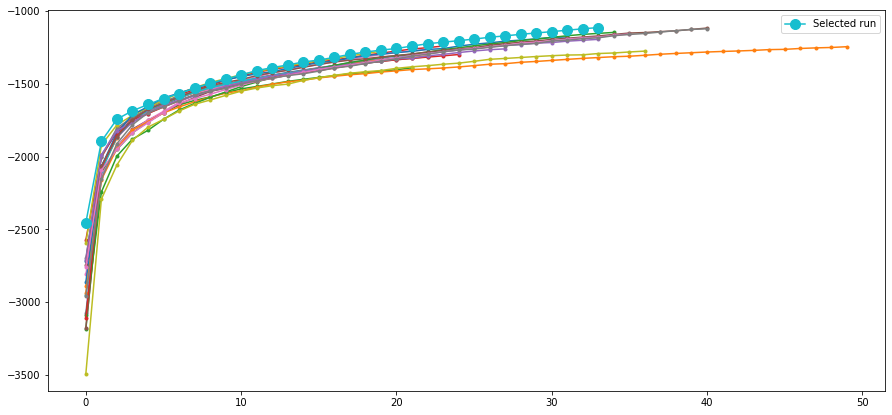

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [60]:
cmm_fx = CMM_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, Xstd_test, Z_test))

Train accuracy of model = 0.794
Test accuracy of model = 0.8308080808080808


In [61]:
prob_Yz = CMM_model.get_global_confusionM()

from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.1330023611194109
Global D (based on normalized Frobenius) = 0.12698166119634371


### Groups found

In [47]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.9842 0.0127 0.0031]


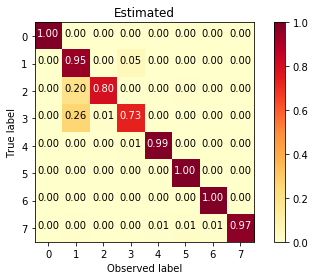

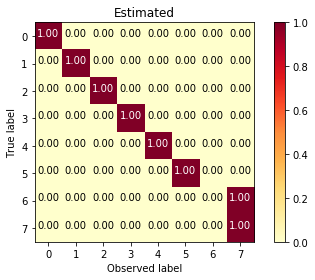

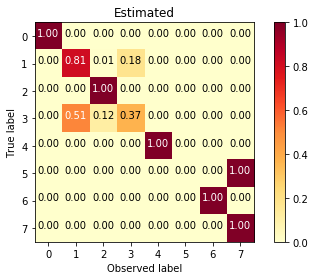

In [48]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

#### With priors= "laplace"
smooth confusion matrices

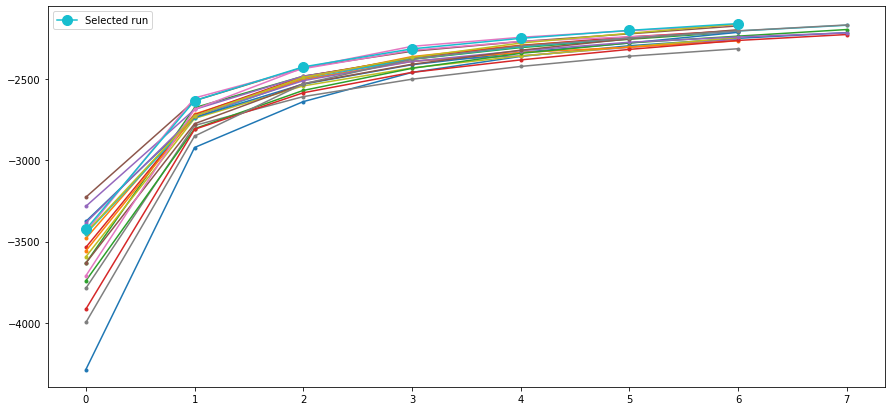

In [17]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [40]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.9987 0.0011 0.0002]


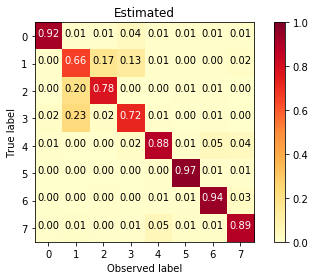

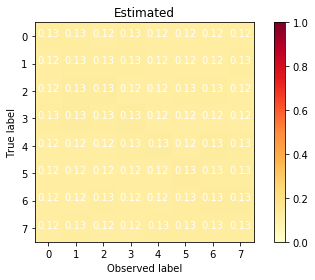

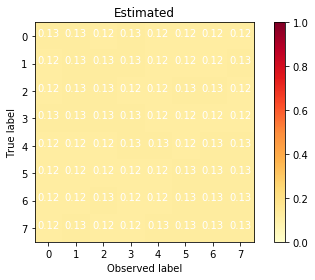

In [41]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

In [ ]:
## usar las otras funciones parao btener grupos de anotadoras.. en visualizacion!!

In [18]:
prob_Yzt = []
for t in range(y_obs.shape[1]):
    conf = CMM_model.get_ann_confusionM(Xstd_train, y_obs[:,t])
    
    prob_Yzt.append(conf)
prob_Yzt = np.asarray(prob_Yzt)
prob_Yzt

array([[[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.8403, 0.015 , ..., 0.    , 0.0031, 0.0153],
        [0.    , 0.1471, 0.8478, ..., 0.0051, 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 0.999 , 0.0005, 0.    ],
        [0.    , 0.    , 0.    , ..., 0.0016, 0.994 , 0.0043],
        [0.    , 0.0043, 0.    , ..., 0.0135, 0.0052, 0.9305]],

       [[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.8403, 0.015 , ..., 0.    , 0.0031, 0.0153],
        [0.    , 0.1471, 0.8478, ..., 0.0051, 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 0.999 , 0.0005, 0.    ],
        [0.    , 0.    , 0.    , ..., 0.0016, 0.994 , 0.0043],
        [0.    , 0.0043, 0.    , ..., 0.0135, 0.0052, 0.9305]],

       [[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.8403, 0.015 , ..., 0.    , 0.0031, 0.0153],
        [0.    , 0.1471, 0.8478, ..., 0.0051, 0.    , 0.    ],
        ...,
        [0. 

## Our Proposed - C-MoA

#### Auxiliar representation with variable number of annotations per annotator and identity

In [14]:
y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
print("Individual sparse representation, variable shape (N,)= ",y_cat_var.shape)
K = y_cat_var[0].shape[1]
print("one-hot vectors of K-dimensions, K=",K)
y_cat_var

Individual sparse representation, variable shape (N,)=  (1000,)
one-hot vectors of K-dimensions, K= 8


array([array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0

In [25]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


#### Fixed annotators representation (non trainable embedding)

In [26]:
T= np.concatenate(A_idx_var).max() +1
A_rep = np.zeros((T, K))
for i in range(N):
    for l, t_idx in enumerate(A_idx_var[i]):
        obs_t = y_cat_var[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (59, 8)


In [27]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K,input_length=1, 
                         trainable=False,weights=[A_rep]))
#                         trainable=True))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 8)              472       
_________________________________________________________________
reshape_1 (Reshape)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 75        
Total params: 763
Trainable params: 291
Non-trainable params: 472
_________________________________________________________________


In [28]:
from codeE.methods import CMOA
CMOA_model = CMOA(M=M_seted) 
#CMOA_model = CMOA(M=M_seted, init_Z='softmv', n_init_Z=0, n_init_G=0, priors=1) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMOA_model.set_model(aux_model, ann_model=group_model, **args)
#CMOA_model.set_model(group_model) #you also can set it manually

# if you want you can initialize step E forcing some method
#CMOA_model.init_E(y_cat_var, A_idx_var, method="hardmv")
#CMOA_model.get_qestimation()

In [29]:
#logL_hists,i_r = CMOA_model.multiples_run(20,Xstd_train,y_cat_var, A_idx_var, 
#                                   max_iter=EPOCHS_BASE,tolerance=TOL) 

CMOA_model.fit(Xstd_train, y_cat_var, A_idx_var, runs = 20,max_iter=EPOCHS_BASE,tolerance=TOL) 

Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Pre-train network on 3 epochs... Done!
Iter 1/50
M step: done,  E step: done //  (in 1.21 sec)	logL: -1834.175	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1575.102	Tol1: 0.14125	Tol2: 0.45987	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1434.704	Tol1: 0.08914	Tol2: 0.38344	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1382.712	Tol1: 0.03624	Tol2: 0.35316	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1338.089	Tol1: 0.03227	Tol2: 0.26707	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1299.732	Tol1: 0.02867	Tol2: 0.20430	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1258.728	Tol1: 0.03155	Tol2: 0.17960	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1229.173	Tol1: 0.02348	Tol2: 0.16210	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1196.894	Tol1: 0.02626	Tol

M step: done,  E step: done //  (in 0.09 sec)	logL: -1612.134	Tol1: 0.12471	Tol2: 0.45332	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1523.101	Tol1: 0.05523	Tol2: 0.38254	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1450.273	Tol1: 0.04782	Tol2: 0.38179	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1415.077	Tol1: 0.02427	Tol2: 0.32919	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1381.001	Tol1: 0.02408	Tol2: 0.27673	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1338.620	Tol1: 0.03069	Tol2: 0.21333	
Iter 8/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1306.831	Tol1: 0.02375	Tol2: 0.17482	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1275.469	Tol1: 0.02400	Tol2: 0.15133	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1241.796	Tol1: 0.02640	Tol2: 0.14468	
Iter 11/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1222.412	Tol1: 0.01561	Tol2: 0.13775

M step: done,  E step: done //  (in 0.08 sec)	logL: -903.898	Tol1: 0.00678	Tol2: 0.03675	
Iter 44/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -898.414	Tol1: 0.00607	Tol2: 0.03360	
Iter 45/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -898.498	Tol1: 0.00009	Tol2: 0.02803	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Pre-train network on 3 epochs... Done!
Iter 1/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -1804.166	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1590.116	Tol1: 0.11864	Tol2: 0.40600	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1465.091	Tol1: 0.07863	Tol2: 0.36103	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1396.327	Tol1: 0.04694	Tol2: 0.31653	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1351.479	Tol1: 0.03212	Tol2: 0.27309	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1312.272	Tol1: 0.0

M step: done,  E step: done //  (in 0.08 sec)	logL: -1490.748	Tol1: 0.06377	Tol2: 0.44068	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1422.647	Tol1: 0.04568	Tol2: 0.40833	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1367.108	Tol1: 0.03904	Tol2: 0.37986	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1328.026	Tol1: 0.02859	Tol2: 0.27966	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1296.108	Tol1: 0.02403	Tol2: 0.24709	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1267.137	Tol1: 0.02235	Tol2: 0.22004	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -1237.793	Tol1: 0.02316	Tol2: 0.19431	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -1215.789	Tol1: 0.01778	Tol2: 0.17899	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1192.171	Tol1: 0.01943	Tol2: 0.15434	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1169.510	Tol1: 0.01901	Tol2: 0.1206

M step: done,  E step: done //  (in 0.07 sec)	logL: -998.170	Tol1: 0.01170	Tol2: 0.04255	
Iter 27/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -989.994	Tol1: 0.00819	Tol2: 0.03411	
Iter 28/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -985.240	Tol1: 0.00480	Tol2: 0.03217	
Iter 29/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -979.143	Tol1: 0.00619	Tol2: 0.03367	
Iter 30/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -975.064	Tol1: 0.00417	Tol2: 0.03191	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -965.331	Tol1: 0.00998	Tol2: 0.03502	
Iter 32/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -952.670	Tol1: 0.01312	Tol2: 0.03318	
Iter 33/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -951.050	Tol1: 0.00170	Tol2: 0.03242	
Iter 34/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -943.185	Tol1: 0.00827	Tol2: 0.03262	
Iter 35/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -936.909	Tol1: 0.00665	Tol2: 0.03178	
I

([array([-1834.1752, -1575.1023, -1434.7041, -1382.7124, -1338.089 ,
         -1299.7321, -1258.7275, -1229.1731, -1196.8939, -1170.6561,
         -1148.2046, -1123.8114, -1109.4269, -1090.6081, -1069.5113,
         -1051.2341, -1039.367 , -1025.1472, -1007.394 ,  -995.1133,
          -983.3548,  -968.1803,  -960.7478,  -947.9787,  -936.8886,
          -924.8581,  -917.8101,  -912.4672,  -900.0966,  -890.3181,
          -885.7169,  -884.2515,  -875.0939,  -866.4655,  -864.1069,
          -851.9714,  -843.7308,  -840.395 ,  -832.4905,  -822.9744,
          -816.5052]),
  array([-1849.0438, -1655.8593, -1552.1261, -1479.9951, -1425.0153,
         -1386.2489, -1340.8918, -1310.2722, -1278.3674, -1256.5716,
         -1229.1103, -1205.2017, -1178.8023, -1155.788 , -1127.988 ,
         -1113.2223, -1097.003 , -1077.1631, -1061.3928, -1046.8758,
         -1034.2262, -1018.3969, -1006.879 ,  -996.2406,  -984.9175,
          -979.7311,  -973.814 ,  -964.0504,  -954.9052,  -945.1894,
          -

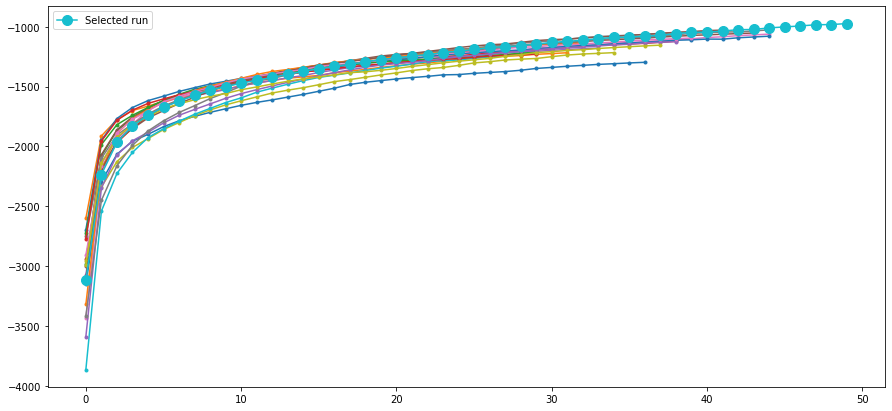

In [20]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [31]:
cmoaK_fx = CMOA_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, Xstd_test, Z_test))

Train accuracy of model = 0.801
Test accuracy of model = 0.8223905723905723


In [32]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Yzt = CMOA_model.get_ann_confusionM(A) # estimate of conf_matrix_I

from codeE.evaluation import Individual_D, D_JS, D_NormF
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.24872775442504463
Individual D_NormF =  0.1934630605199904


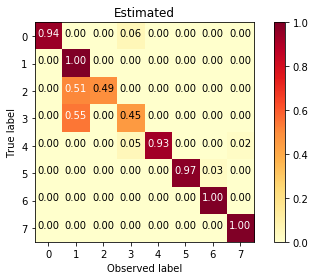

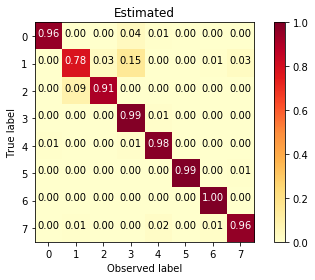

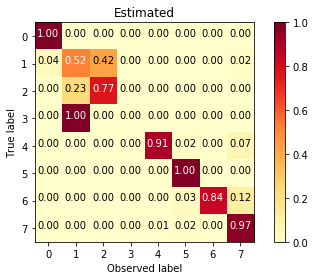

In [23]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

#### With priors= "laplace"
smooth confusion matrices

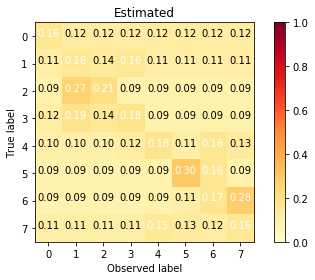

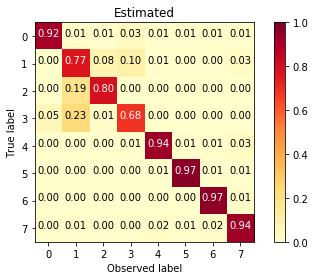

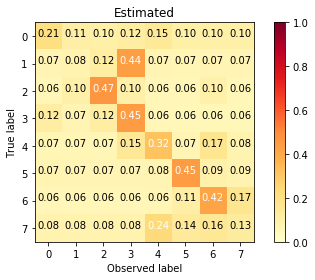

In [52]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

In [ ]:
## global D en visualizacion

### Compare trained models

In [29]:
#Import it:
from codeE.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [29]:
aux_tr = []
aux_te = []
eps = []
for _ in range(20):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    Z_train_pred = model_UB.predict_classes(Xstd_train)
    Z_test_pred = model_UB.predict_classes(Xstd_test)

    evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    eps.append(len(hist.epoch))
    
print("Epochs: ",np.mean(eps))
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("LabelMe_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("LabelMe_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("LabelMe_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("LabelMe_Ideal_test_std.csv",index=False)
final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

Epochs:  11.55


,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.97315,0.97315,0.974759,0.012285,0.012285,0.012054


In [17]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True)

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.924285,0.924285,0.925649,0.005386,0.005386,0.005658


In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test).argmax(axis=-1)

In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(T_idx_unique)  ########

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [66]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

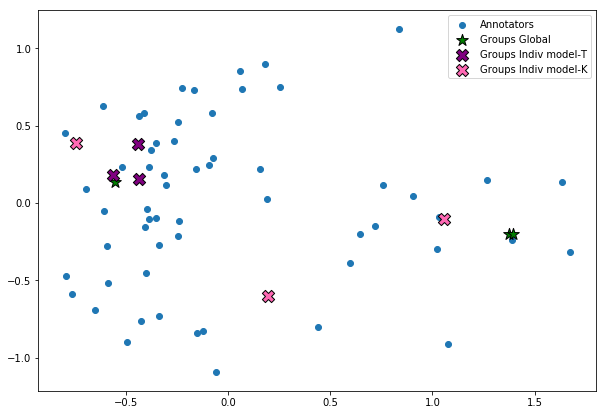

In [67]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo